<a href="https://colab.research.google.com/github/prometheusDE/mylastai/blob/master/mylastai_0008_project_handlevideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from google.colab import drive
drive.mount('/content/gdrive')

1. Install Tensorflow and Tensorflow Dataset Extension


%%capture
!pip install tensorflow==2.1.0
!pip install matplotlib==3.2.1
!pip install mxnet-cu101mkl==1.6.0

!nvcc --version

!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali-tf-plugin

2. Handle Video File

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import os.path

# https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/sequence_processing/video/video_reader_simple_example.html

In [2]:
batch_size=10
sequence_length=8
initial_prefetch_size=16
#video_directory = '/content/gdrive/My Drive/CycleAI/Compressed/480p/20200308'
video_directory = '//media/backhaus/LaCie/CycleAI/Compressed/480p/20200429'
# Get all m4v Files, Note: If we get non-video files in the list, nvidia dali will crash the notebook instance
video_files=[video_directory + '/' + f for f in os.listdir(video_directory) if f.endswith('.m4v')]
shuffle=False
n_iter=1

In [3]:
print(video_files)

['//media/backhaus/LaCie/CycleAI/Compressed/480p/20200429/2020-04-29_CycleAI_0017_Hinfahrt_IFF_001.m4v', '//media/backhaus/LaCie/CycleAI/Compressed/480p/20200429/2020-04-29_CycleAI_0017_Hinfahrt_IFF_002.m4v', '//media/backhaus/LaCie/CycleAI/Compressed/480p/20200429/2020-04-29_CycleAI_0018_Rueckfahrt_IFF_001.m4v', '//media/backhaus/LaCie/CycleAI/Compressed/480p/20200429/2020-04-29_CycleAI_0018_Rueckfahrt_IFF_002.m4v']


In [4]:
class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data, shuffle):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed=16)
        self.input = ops.VideoReader(device="gpu", filenames=data, sequence_length=sequence_length,
                                     shard_id=0, num_shards=1,
                                     random_shuffle=shuffle, initial_fill=initial_prefetch_size)

        # self.transpose = ops.Transpose(device="gpu", perm=[0, 3, 1, 2])

    def define_graph(self):
        raw_img = self.input(name="Reader")
        # trans_img = self.transpose(raw_img)
        return raw_img

In [5]:
# Simple Test for video loader pipeline
pipe = VideoPipe(batch_size=batch_size, num_threads=2, device_id=0, data=video_files, shuffle=shuffle)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

(10, 8, 480, 720, 3)


3. Visualize Frames

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
def show_sequence(sequence):
    columns = 4
    rows = (sequence_length + 1) // columns
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

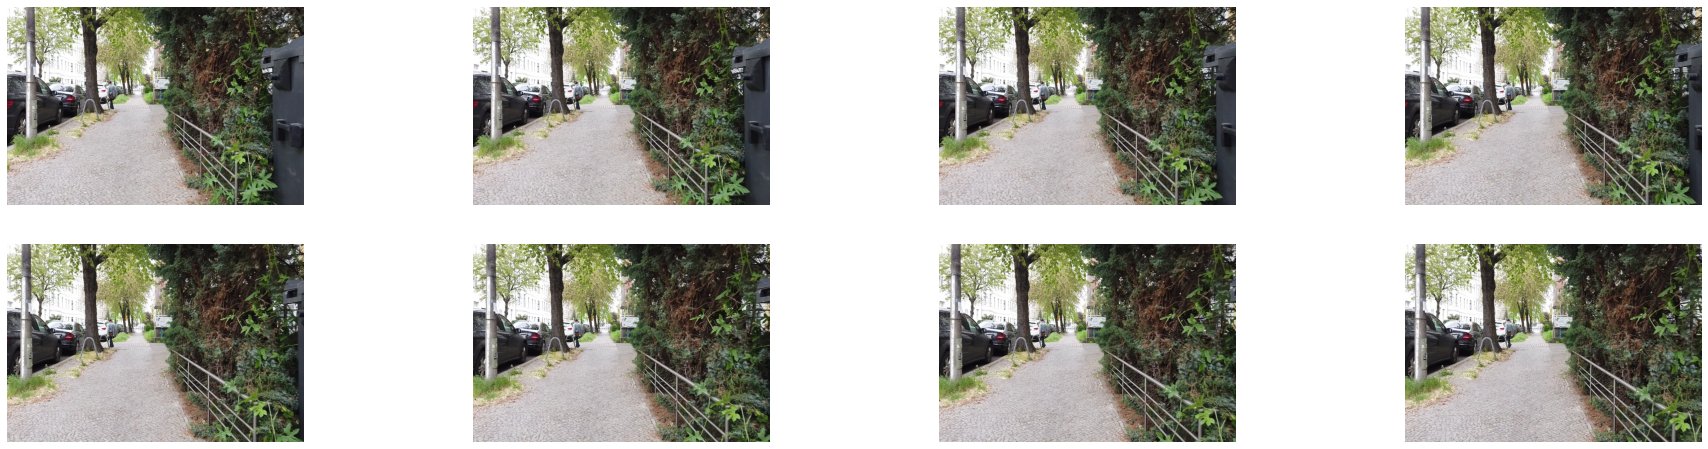

In [8]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[1])

4. Try to feed data into a street segmentation network

Example: https://github.com/onnx/models/blob/master/vision/object_detection_segmentation/duc/duc-inference.ipynb

In [9]:
import mxnet as mx
import cv2 as cv
import numpy as np
import os
from PIL import Image
import math
from collections import namedtuple
from mxnet.contrib.onnx import import_model
from duc_postprocess import score_model
from duc_preprocess import preprocess


In [10]:
def get_model(ctx, model_path, im):
    # import ONNX model into MXNet symbols and params
    sym,arg,aux = import_model(model_path)
    # define network module
    mod = mx.mod.Module(symbol=sym, data_names=['data'], context=ctx, label_names=None)
    # bind parameters to the network
    mod.bind(for_training=False, data_shapes=[('data', (1, im.shape[1], im.shape[2], im.shape[3]))], label_shapes=mod._label_shapes)
    mod.set_params(arg_params=arg, aux_params=aux,allow_missing=True, allow_extra=True)
    return mod

In [11]:
# Download ONNX model
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/duc/ResNet101_DUC_HDC.onnx')

# Determine and set context
if len(mx.test_utils.list_gpus())==0:
    ctx = mx.cpu()
else:
    ctx = mx.gpu(0)

pre = preprocess(sequences_out[0,0])
print(pre.shape)
# Load ONNX model
mod = get_model(ctx, 'ResNet101_DUC_HDC.onnx', pre)

(1, 3, 480, 720)


In [12]:
# Preprocess Sequence of images
img_raw = sequences_out[1,1]
img_pre = preprocess(img_raw)
print(pre.shape)
# Do inference... #,blended_img,raw
conf,result_img, raw = score_model(img_pre, img_raw, mod, (img_pre.shape[2], img_pre.shape[3]))

(1, 3, 480, 720)


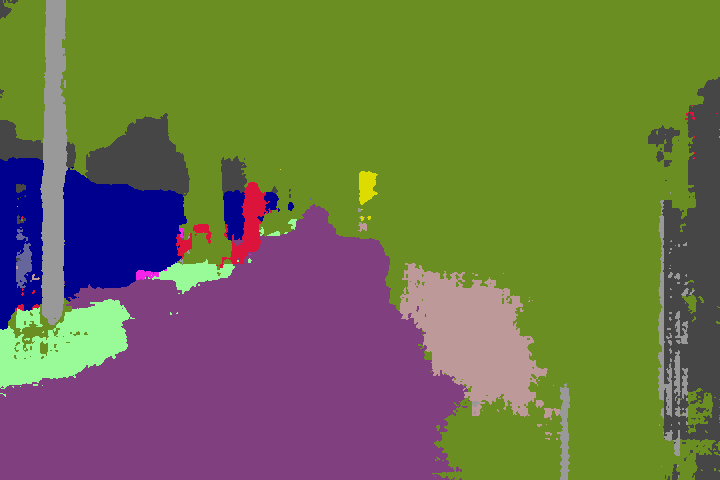

In [13]:
result_img